In [1]:
from nltk.stem.porter import PorterStemmer
import json
import re
import math
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

# Data Process
Read the training data to get the number of users and restaurants

In [24]:
## objectives (2)
## 1. get the number of users & items in training data (currently with size of 40,000)
## 2. get Global: mu, bias_user, bias_item

# get the size of user_id & business_id
user_id = []
business_id = []
# with open('yelp_data/yelp_testing.json') as f:
with open('yelp_data/training_at5.json') as f:
    for line in f:
        temp = json.loads(line)        
        user_id.append(temp["user_id"])
        business_id.append(temp["business_id"])
        
print user_id.__len__()
# print business_id.__len__()

# This is without duplication: set
user_id = set(user_id)
business_id = set(business_id)

print user_id.__len__()
print business_id.__len__()
print "done"

255814
22273
12725
done


# Baseline Calculation
Overall average named "average" 

User bias named "origin_user_bias"

Restaurant bias named "origin_business_bias"

In [3]:
# calculate the Global bias
# initialize the dictionary:
#   average --> global average
#   user_bias_list = {user_id --> a list of scores}
#   business_bias_list = {business_id --> a list of scores}
average = 0
num_star = 0
user_bias_list = {}
origin_user_bias = {}
business_bias_list = {}
origin_business_bias = {}
for value in user_id:
    user_bias_list[value] = []
    origin_user_bias[value] = 0
for value in business_id:
    business_bias_list[value] = []
    origin_business_bias[value] = 0

# adding the list
# with open('yelp_data/alg_train.json') as f:
with open('yelp_data/training_at5.json') as f:
    for line in f:
        # get the infor from file
        temp = json.loads(line)        
        cur_user_id = temp["user_id"]
        cur_business_id = temp["business_id"]
        star = temp["stars"]
        # filling the dictionary & calculate the average
        average += star
        num_star += 1
        user_bias_list[cur_user_id].append(star)
        business_bias_list[cur_business_id].append(star)

# average
average /= float(num_star)
# calculate: user_bias = {user_id --> average score} & business_bias = {business_id --> average score}
for user_key in user_bias_list:
    b_x = sum(user_bias_list[user_key]) / float(user_bias_list[user_key].__len__()) - average
    origin_user_bias[user_key] = b_x
for business_key in business_bias_list:
    b_i = sum(business_bias_list[business_key]) / float(business_bias_list[business_key].__len__()) - average
    origin_business_bias[business_key] = b_i
    
print "done"

done


# User and Restaurant Matching
Make "user_id" in the data match the index in latent factor model

Do the same to "business_id"

In [4]:
user_id = list(user_id)
user_idx = range(user_id.__len__())
user_match = dict(zip(user_id, user_idx))

business_id = list(business_id)
business_idx = range(business_id.__len__())
business_match= dict(zip(business_id, business_idx))

print "done"

done


# Sochastic Gradient Decent training function with baseline score

In [5]:
## SGD training function interface
# inputs(10):
# ite: number of iteration
# lam: regulation factor: assume lam1 == lam2 == lam3 == lam4
# mu: study rate: assume mu1 = mu2
# k: number of concept in latent factor
# m: number of users
# n: number of items
# user_match: from user_id to index i
# business_match: from business_id to index j
# user_bias & business_bias: should equal to original user_bias & business_bias, whose values won't change
# outputs(4):
# latent factor q & p, updated user_bias & business_bias
def SGD_train(file_name, ite, lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average):
    # initialization
    q = np.random.rand(m, k) * sqrt(5.0 / k)  # normalization
    p = np.random.rand(n, k) * sqrt(5.0 / k)
    fig = empty(ite)

    ## essential steps
    # 1. read the file to get user_id, business_id, stars
    # 2. find the corresponding index of user_id, business_id in q and p
    # 3. Stochastic GD alg
    for num in range(0, ite):
#         print num
        # read the file to update q & p
        with open(file_name) as f:
            for line in f:
                temp = json.loads(line)
                cur_user_id = temp["user_id"]
                cur_business_id = temp["business_id"]
                # get initialized b_x, b_i
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id]
                i = user_match[cur_user_id]                  # get the index of corresponding user in q
                j = business_match[cur_business_id]          # get the index of corresponding business in p
                star = temp["stars"]
                # updating p, q, b_x & b_i
                eps = 2 * (star - (average + b_x + b_i + dot(q[i, ], p[j, ])))
                temp_q = q[i, ] + mu * (eps * p[j, ] - 2 * lam * q[i, ])
                temp_p = p[j, ] + mu * (eps * q[i, ] - 2 * lam * p[j, ])
                q[i, ] = temp_q
                p[j, ] = temp_p
                user_bias[cur_user_id] = b_x + mu * (eps - 2 * lam * b_x)
                business_bias[cur_business_id] = b_i + mu * (eps - 2 * lam * b_i)
    
        # read the file to calculate the error
#         error = 0
#         with open(file_name) as f:
#             for line in f:
#                 temp = json.loads(line)
#                 cur_user_id = temp["user_id"]
#                 cur_business_id = temp["business_id"]
#                 i = user_match[cur_user_id]
#                 j = business_match[cur_business_id]
#                 b_x = user_bias[cur_user_id]
#                 b_i = business_bias[cur_business_id] 
#                 star = temp["stars"]
#                 error += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
#         # add the regulation error (combine them in all)
#         # regulation for b_x & b_i
#         regu_user_bias = 0
#         regu_business_bias = 0
#         for key in user_bias:
#             regu_user_bias += user_bias[key] ** 2
#         for key in business_bias:
#             regu_business_bias += business_bias[key] ** 2
#         error += lam * (sum(q ** 2) + sum(p ** 2) + regu_user_bias + regu_business_bias)
#         fig[num] = error        

#     # examine: plot the graph 
#     plt.plot(range(0, ite), fig)
#     plt.show()            
#     print error             
#     print "done"
    return q, p, user_bias, business_bias

# Sochastic Gradient Decent testing function with baseline score

In [8]:
## SGD testing function with baseline interface
# input(7):
# file_name
# q and p
# user_match & business_match
# user_bias & business_bias
# average
# output(1):
# RMSE
def SGD_test(file_name, q, p, user_match, business_match, user_bias, business_bias, average):
    extrapolate_star = []
    origin_star = []
    numOfTest = 0
    RMSE = 0
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            # check if current review is in the Matrix
            if cur_user_id in user_match and cur_business_id in business_match:
                numOfTest += 1
                i = user_match[cur_user_id]
                j = business_match[cur_business_id]
                star = temp["stars"]
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id] 
                RMSE += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
        print numOfTest
        RMSE = sqrt(RMSE / float(numOfTest))    
    return RMSE

user_bias = dict(origin_user_bias)
business_bias = dict(origin_business_bias)
# training
[q, p, user_bias, business_bias] = SGD_train(
        train_file, ite, cur_lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average)

print "done"

done


# Turing Procedure
1. Regulation tuning lam from 0.3 to 0.9 with step 1.3

31930
0.4
1.06755506305
31930
0.5
1.06530791344
31930
0.6
1.06391963729
31930
0.7
1.0634501369
31930
0.8
1.06347208013
31930
0.9
1.06372790607
31930
1.0
1.0647235224
31930
1.1
1.06569745701
31930
1.2
1.06664610303
31930
1.3
1.06786867555


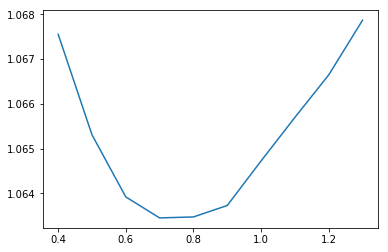

done


In [16]:
## tuning parameter
ite = 15                                  
lam = [(x + 1) / float(10) for x in range(3, 13)]                 
mu = 0.005                                
k = 20                                    
m = user_id.__len__()                     
n = business_id.__len__()        
output = empty(lam.__len__())
# train_file = 'yelp_data/alg_train.json'
train_file = 'yelp_data/training_at5.json'
test_file = 'yelp_data/testing_at5.json'

for cur_lam in lam:
    user_bias = dict(origin_user_bias)
#     user_bias = origin_user_bias
    business_bias = dict(origin_business_bias)
#     business_bias = origin_business_bias
    # training
    [q, p, user_bias, business_bias] = SGD_train(
        train_file, ite, cur_lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average)
    # testing
    RMSE = SGD_test(test_file, q, p, user_match, business_match, user_bias, business_bias, average)
    output[lam.index(cur_lam)] = RMSE
    print cur_lam
    print RMSE

plt.plot(lam, output)
plt.show()                
print "done"    

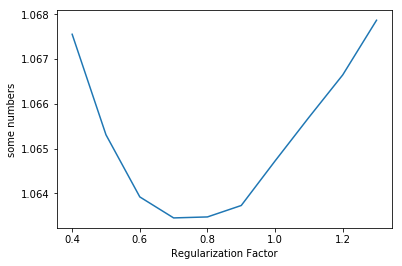

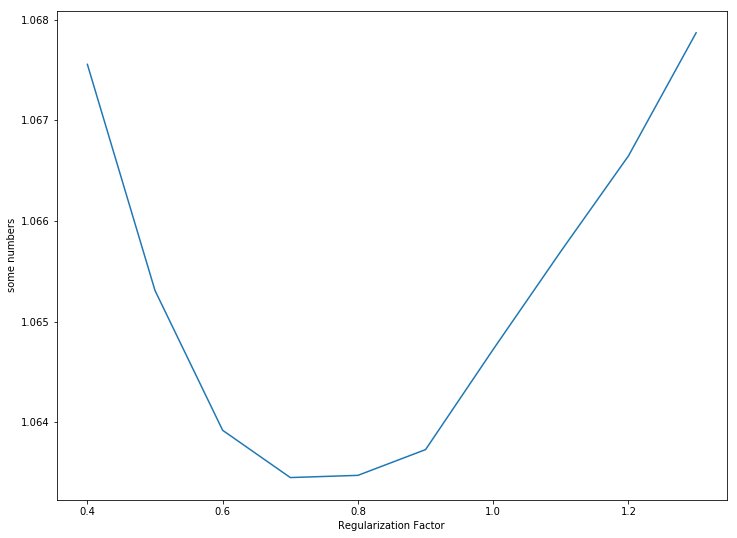

done


In [22]:
plt.plot(lam, output)
plt.xlabel("Regularization Factor")
plt.ylabel('some numbers')
# plt.show()    
width = 12
height = 9
plt.figure(figsize = (width, height))
plt.show()
print "done" 